In [1]:
import pandas as pd
import ast

import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

import statsmodels.api as sm

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Elon Musk's Tweets

In [2]:
elon = pd.read_csv('twitter/elonmusk_tweets.csv')

In [3]:
elon.text = elon.text.str.lstrip('b')
elon.created_at = pd.to_datetime(elon.created_at)
elon['date'] = elon.created_at.apply(lambda x: x.date())

In [4]:
elon.head()

,id,created_at,text,date
0,940620874952073216,2017-12-12 16:34:27,"'35,000'",2017-12-12
1,940359019947999232,2017-12-11 23:13:56,'And those are just the really big ones. The P...,2017-12-11
2,940126370780160000,2017-12-11 07:49:28,'@Justin_Levy04 Safest flamethrower ever',2017-12-11
3,940125978797281281,2017-12-11 07:47:54,"'I know it\xe2\x80\x99s a little off-brand, bu...",2017-12-11
4,940056523304181762,2017-12-11 03:11:55,"'After 50k hats, we will start selling The Bor...",2017-12-11


In [5]:
# NLP processing from the nltk package
# Instantiate tokenizer to break text into lists of words
#tokenizer = RegexpTokenizer(r'\w+')
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9_@-]+')
# Instantiate lemmatizer to turn plural words into singular for better comparison
lemmatizer = WordNetLemmatizer()

In [6]:
# First let's turn each title into a list of words
elon['nlp_text'] = elon.text.apply(lambda x: tokenizer.tokenize(x.lower()))
# Then we'll use the lemmatizer to change plurals to singulars to group them
elon.nlp_text = elon.nlp_text.apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
# And rejoin the lists of words to one string for the count vectorizer
elon.nlp_text = elon.nlp_text.apply(lambda x: ' '.join(x))

In [7]:
elon[['text', 'nlp_text']].head(10)

,text,nlp_text
0,"'35,000'",35 000
1,'And those are just the really big ones. The P...,and those are just the really big one the perm...
2,'@Justin_Levy04 Safest flamethrower ever',@justin_levy04 safest flamethrower ever
3,"'I know it\xe2\x80\x99s a little off-brand, bu...",i know it xe2 x80 x99s a little off-brand but ...
4,"'After 50k hats, we will start selling The Bor...",after 50k hat we will start selling the boring...
5,"'Over 30,000 hats sold!'",over 30 000 hat sold
6,'@tiamaria68uk Plus a towel and a sign saying ...,@tiamaria68uk plus a towel and a sign saying x...
7,"'On Tuesday, SpaceX will attempt to refly both...",on tuesday spacex will attempt to refly both a...
8,'@tiamaria68uk Yes',@tiamaria68uk yes
9,'@FortuneTech Do it',@fortunetech do it


In [8]:
elon.nlp_text = elon.nlp_text + ' '
elon = elon.groupby('date')['nlp_text'].sum()
elon = pd.DataFrame(elon)
elon.columns = ['elon_tweet']

## Tesla company tweets

In [9]:
tesla = pd.read_csv('twitter/Tesla_tweets.csv')

In [10]:
tesla.text = tesla.text.str.lstrip('b')
tesla.created_at = pd.to_datetime(tesla.created_at)
tesla['date'] = tesla.created_at.apply(lambda x: x.date())

In [11]:
tesla.head()

,id,created_at,text,date
0,940293634825453568,2017-12-11 18:54:07,"'@quizprep We can get this sorted out asap, ca...",2017-12-11
1,939217750978736128,2017-12-08 19:38:56,'RT @woodhaus2: Early sketch of BAMF #BAMF Sem...,2017-12-08
2,938970514655035393,2017-12-08 03:16:30,'RT @Mayor_Jeff: Check out the new 20-stall el...,2017-12-08
3,936700961669517312,2017-12-01 20:58:06,'New study finds regular car dealers are still...,2017-12-01
4,936475314758098944,2017-12-01 06:01:28,'RT @nytimesworld: \xe2\x80\x9cTesla will get ...,2017-12-01


In [12]:
# First let's turn each title into a list of words
tesla['nlp_text'] = tesla.text.apply(lambda x: tokenizer.tokenize(x.lower()))
# Then we'll use the lemmatizer to change plurals to singulars to group them
tesla.nlp_text = tesla.nlp_text.apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
# And rejoin the lists of words to one string for the count vectorizer
tesla.nlp_text = tesla.nlp_text.apply(lambda x: ' '.join(x))

In [13]:
tesla[['text', 'nlp_text']].head(10)

,text,nlp_text
0,"'@quizprep We can get this sorted out asap, ca...",@quizprep we can get this sorted out asap can ...
1,'RT @woodhaus2: Early sketch of BAMF #BAMF Sem...,rt @woodhaus2 early sketch of bamf bamf semi @...
2,'RT @Mayor_Jeff: Check out the new 20-stall el...,rt @mayor_jeff check out the new 20-stall elec...
3,'New study finds regular car dealers are still...,new study find regular car dealer are still tr...
4,'RT @nytimesworld: \xe2\x80\x9cTesla will get ...,rt @nytimesworld xe2 x80 x9ctesla will get the...
5,"'New @UCSUSA study shows that across the US, d...",new @ucsusa study show that across the u drivi...
6,'@Seanlocklear15 Jump to around 3:25',@seanlocklear15 jump to around 3 25
7,'Model X racing a gasoline sports car while to...,model x racing a gasoline sport car while towi...
8,'Going into plaid https://t.co/OUU9s7CUwI',going into plaid http t co ouu9s7cuwi
9,'BAMF https://t.co/r535Hv4Xz7',bamf http t co r535hv4xz7


In [14]:
tesla.nlp_text = tesla.nlp_text + ' '
tesla = tesla.groupby('date')['nlp_text'].sum()
tesla = pd.DataFrame(tesla)
tesla.columns = ['tesla_tweet']

## Techmeme headlines

In [15]:
techmeme = pd.read_csv('web_scraping/techmeme.csv', index_col=0)

In [16]:
techmeme['date_time'] = pd.to_datetime(techmeme.date)
techmeme.date = techmeme.date_time.apply(lambda x: x.date())
techmeme.extra_sources = techmeme.extra_sources.apply(lambda x: ast.literal_eval(x))

In [17]:
techmeme['sources'] = techmeme.extra_sources.copy()
# Ben helped me with this lovely for loop...
for i, list_ in enumerate(techmeme.sources):
    list_.append(techmeme.original_source[i])

In [18]:
techmeme.original_title = techmeme.original_title.apply(lambda x: x.replace('\n', ''))
techmeme.extra_titles = techmeme.extra_titles.apply(lambda x: x.lstrip('[').rstrip(']'))
techmeme['titles'] = techmeme.original_title + ' ' + techmeme.extra_titles

In [19]:
# First let's turn each title into a list of words
techmeme['nlp_text'] = techmeme.titles.apply(lambda x: tokenizer.tokenize(x.lower()))
# Then we'll use the lemmatizer to change plurals to singulars to group them
techmeme.nlp_text = techmeme.nlp_text.apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
# And rejoin the lists of words to one string for the count vectorizer
techmeme.nlp_text = techmeme.nlp_text.apply(lambda x: ' '.join(x))

In [20]:
techmeme.columns = ['date', 'original_source', 'original_title', 'extra_sources',
       'extra_titles', 'date_time', 'news_sources', 'titles', 'news_text']

In [21]:
techmeme.news_text = techmeme.news_text + ' '
techmeme = techmeme.groupby('date')['news_sources', 'news_text'].sum()

# Combine them onto stock data

In merging, I noticed that I was not retaining the same amounts of information.  I realized that since I do not have stock information on weekends, I have nothing to link tweets or news that happens over the weekend.  I should push this to help predict Monday prices, but I am not yet sure how to do that.

In [22]:
stock = pd.read_csv('TESLAHistoricalQuotes.csv')
stock = stock.drop(0,0)
stock.date = pd.to_datetime(stock.date)
stock.date = stock.date.apply(lambda x: x.date())
stock = stock.sort_values('date')
stock.volume = stock.volume.astype(float)
stock.set_index(stock.date, inplace=True)
stock = stock.drop('date', 1)

In [23]:
stock = pd.merge(stock, techmeme, how='left', left_index=True, right_index=True)
stock = pd.merge(stock, tesla, how='left', left_index=True, right_index=True)
stock = pd.merge(stock, elon, how='left', left_index=True, right_index=True)

In [24]:
stock.tail()

,close,volume,open,high,low,news_sources,news_text,tesla_tweet,elon_tweet
date,,,,,,,,,
2017-11-16,312.50,5794409.0,313.99,318.14,311.30,NaN,NaN,NaN,NaN
2017-11-17,315.05,13720830.0,325.67,326.67,313.15,NaN,NaN,going into plaid http t co ouu9s7cuwi bamf htt...,tesla semi http t co 7vlz7f46ji 0 to 100 km h ...
2017-11-20,308.74,8241821.0,313.79,315.50,304.75,NaN,NaN,NaN,@schesnais good point
2017-11-21,317.81,7256381.0,310.86,318.23,308.71,NaN,NaN,NaN,initial hat offering going great w over 300k i...
2017-11-22,312.60,4913283.0,316.77,317.42,311.84,NaN,NaN,NaN,NaN


### Note on earliest NLP relevant info
1. elon earliest tweet 2013-03-23
2. tesla earliest tweet 2014-02-18
3. techmeme earliest story 2006-12-07

```stock.iloc[915]``` is 2014-02-18

# Run ARIMA Model

In [25]:
mod = sm.tsa.statespace.SARIMAX(stock.close, trend='n', order=(1,1,3), seasonal_order=(0,1,1,80))
results = mod.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              close   No. Observations:                 1866
Model:             SARIMAX(1, 1, 3)x(0, 1, 1, 80)   Log Likelihood               -5456.155
Date:                            Tue, 19 Dec 2017   AIC                          10924.310
Time:                                    17:30:53   BIC                          10957.499
Sample:                                06-29-2010   HQIC                         10936.539
                                     - 11-22-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2551      0.425      0.601      0.548      -0.577       1.087
ma.L1         -0.2205      0.425     -0.518      0.604      -1.054       0.613
ma.L2          0.0068      0.027      0.253      0.800      -0.046       0.059
ma.L3         -0.0481      0.018     -2.700      0.007      -0.083      -0.013
ma.S.L80      -0.9995      2.558     -0.391      0.696      -6.013       4.014
sigma2        22.9819     58.554      0.392      0.695     -91.782     137.746
===================================================================================
Ljung-Box (Q):                       33.16   Jarque-Bera (JB):              1844.42
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):              40.33   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
stock['forecast'] = results.predict(dynamic=False)

In [27]:
stock['next_day_open'] = stock.open.shift(-1) 

In [28]:
stock['target'] = stock.close.shift(-1)

# Use CountVectorizer

In [29]:
temp_df = stock[stock.news_text.notnull()]
cvec = CountVectorizer(stop_words=stopwords.words('english'), ngram_range=(1,2), max_features=1000)
cvec.fit(temp_df.news_text.dropna())
cvec_df  = pd.DataFrame(cvec.transform(temp_df.news_text.dropna()).todense(), columns=cvec.get_feature_names())
cvec_df.index = temp_df.index
cvec_df.columns += " _news_"
stock = stock.join(cvec_df).drop('news_text',1)

temp_df = stock[stock.tesla_tweet.notnull()]
cvec.fit(temp_df.tesla_tweet.dropna())
cvec_df  = pd.DataFrame(cvec.transform(temp_df.tesla_tweet.dropna()).todense(), columns=cvec.get_feature_names())
cvec_df.index = temp_df.index
cvec_df.columns += " _tesla_"
stock = stock.join(cvec_df).drop('tesla_tweet',1)

temp_df = stock[stock.elon_tweet.notnull()]
cvec.fit(temp_df.elon_tweet.dropna())
cvec_df  = pd.DataFrame(cvec.transform(temp_df.elon_tweet.dropna()).todense(), columns=cvec.get_feature_names())
cvec_df.index = temp_df.index
cvec_df.columns += " _elon_"
stock = stock.join(cvec_df).drop('elon_tweet',1)

del temp_df

In [30]:
stock.news_sources = stock.news_sources.fillna('')
mlb = MultiLabelBinarizer()
stock = stock.join(pd.DataFrame(mlb.fit_transform(stock.news_sources), columns=mlb.classes_, index=stock.index))
stock = stock.drop('news_sources', 1)

In [31]:
stock = stock.fillna(0)

In [32]:
stock.head()

,close,volume,open,high,low,forecast,next_day_open,target,000 _news_,10 _news_,...,digitaltrends.com,documentcloud.org,everythingiCafe,iDownloadBlog.com,iDownloadBlog.com iDownloadBlog.com,iLounge,iMore,iPhone Hacks,iPhone in Canada Blog,lists.swift.org Mailing Lists
date,,,,,,,,,,,,,,,,,,,,,
2010-06-29,23.89,18751150.0,19.00,25.0000,17.54,0.000000,25.79,23.83,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2010-06-30,23.83,17165210.0,25.79,30.4192,23.30,23.890019,25.00,21.96,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2010-07-01,21.96,8216789.0,25.00,25.9200,20.27,23.830008,23.00,19.20,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2010-07-02,19.20,5135795.0,23.00,23.1000,18.71,21.959973,20.00,16.11,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2010-07-06,16.11,6858092.0,20.00,20.0000,15.83,19.199988,16.40,15.80,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, roc_auc_score

In [34]:
X_train, X_test, y_train, y_test = train_test_split(stock.drop(['target', 'close', 'open'], 1), stock['target'], test_size=0.3, random_state=42)

In [35]:
from sklearn.linear_model import LinearRegression

In [36]:
lr = LinearRegression()

In [37]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [38]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

In [39]:
scores = cross_val_score(lr, X_train, y_train, cv=6)
print("Cross-validated scores:", scores)
print("Average: ", scores.mean())

Cross-validated scores: [ -2.13697039e+07  -7.38906389e+07  -1.90998464e+07  -1.94298254e+07
  -1.98249349e+08  -1.82890011e+06]
Average:  -55644710.655


Score: -1177536.34718


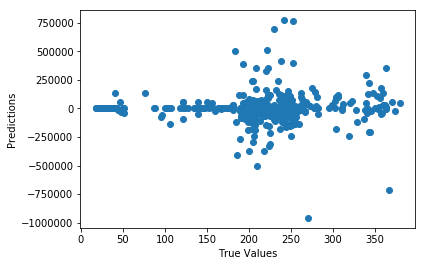

In [40]:
predictions = lr.predict(X_test)
plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")
print("Score:", lr.score(X_test, y_test))
plt.show()

In [41]:
from xgboost import XGBRegressor

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [42]:
xgb = XGBRegressor(gamma=0, learning_rate=0.02, max_depth=3, n_estimators=100)

In [43]:
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.02, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

Score: 0.94280846105


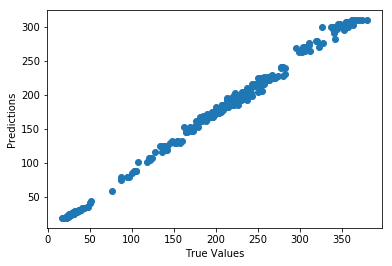

In [44]:
predictions = xgb.predict(X_test)
plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")
print("Score:", xgb.score(X_test, y_test))
plt.show()

In [45]:
from sklearn import metrics

In [48]:
accuracy = metrics.r2_score(y_test, predictions)
print("R2 Accuracy:", accuracy)

R2 Accuracy: 0.94280846105


In [60]:
print("MSE:", metrics.mean_squared_error(y_test, predictions))

MSE: 668.243820278


Damn!  But, how much is the NLP adding?

Score: 0.991110951772
MSE: 102.352151481


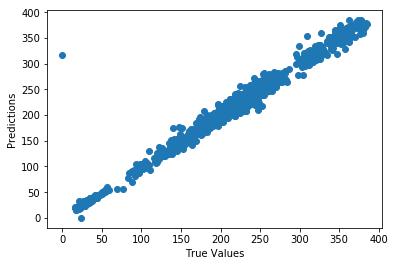

In [58]:
plt.scatter(stock.target, stock.forecast)
plt.xlabel("True Values")
plt.ylabel("Predictions")
print("Score:", metrics.r2_score(stock.target, stock.forecast))
print("MSE:", metrics.mean_squared_error(stock.target, stock.forecast))
plt.show()

Hmmmm. I'm guessing my one outlier is just the last observation since it is probably a zero (using .shift() and there being nothing there).  So my SARIMAX model is accurate, but I sort of knew that already.

In [55]:
stock[['target', 'forecast']].sort_values('target').head()
# YUP, last entry

,target,forecast
date,,
2017-11-22,0.00,317.326469
2010-07-06,15.80,19.199988
2010-07-02,16.11,21.959973
2010-07-09,17.05,17.460010
2010-07-08,17.40,15.800004


In [59]:
print("Score:", metrics.r2_score(stock.iloc[:-1].target, stock.iloc[:-1].forecast))
print("MSE:", metrics.mean_squared_error(stock.iloc[:-1].target, stock.iloc[:-1].forecast))

Score: 0.995793097015
MSE: 48.414491673


And if I predicted the entirety with XGB:

In [63]:
print("MSE:", metrics.mean_squared_error(stock.target, xgb.predict(stock.drop(['target', 'close', 'open'], 1))))

MSE: 650.015530157
